In [396]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import graphviz 
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [3]:
from sklearn.neighbors import DistanceMetric


def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def cluster_score(data_encoded_clustered, metric):
    
    cluster_total = 0
    for cluster in data_encoded_clustered['Cluster'].unique():

        cluster_set = data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster]
        
        cols = list(data_encoded_clustered.columns)
        cols.remove('Cluster')
        
        if len(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster]) == 1:

            cluster_total = 0
        else:
            
            if metric == 'gower':

                cluster_dist = gower_distance(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster][cols]).sum()
                
            elif metric == 'euclidean':
                
                euclidean_df = data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster][cols]
                
                cluster_dist = euclidean_distances(euclidean_df, euclidean_df).sum()            

        cluster_total = cluster_total + cluster_dist
        
    return cluster_total

In [5]:
def centroid_calc(data_encoded_clustered, cont_cols):
     
    clf = NearestCentroid()
    clf.fit(data_encoded_clustered[cont_cols], data_encoded_clustered['Cluster'])

    return clf.centroids_

In [6]:
def sum_of_squares(centroids, data_encoded_clustered,clustering_cols):
    
    total_dist = 0
    for cluster in range(centroids.shape[0]):

        centroid_dist = 0
        for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster].index):

            centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[clustering_cols].loc[i]) - centroids[cluster]).sum()

        total_dist = total_dist + centroid_dist
    return total_dist

In [7]:
def plot_tree(model, feature_names_abalone, file_name, plot_format):
    
    dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=feature_names_abalone,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    
    graph = graphviz.Source(dot_data)  
    graph.render(file_name,format=plot_format) 
        
    return graph

In [8]:
data = pd.read_excel('abaloneCleaned.xlsx')

In [9]:
cont_cols =['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

In [10]:
# data_prof = ProfileReport(data)
# data_prof.to_file(output_file='data_profile.html')

In [11]:
# sns.set_theme(style="white")
# sns.pairplot(data[cont_cols])
# plt.savefig('images/01 splom before.png',bbox_inches = 'tight');

In [12]:
remove_height = list(data[(data['Height'] <= np.percentile(data['Height'], 0.001)) | (data['Height'] > np.percentile(data['Height'], 99.95))].index)
data = data[data.index.isin(remove_height) == False].reset_index(drop=True)

In [13]:
# sns.set_theme(style="white")
# sns.pairplot(data[cont_cols])
# plt.savefig('images/02 splom after.png',bbox_inches = 'tight');

#### Obtain Correlation Matrix

In [14]:
corr_mat = data.corr()
# corr_mat.to_csv('cor_matrix.csv')

#### Separate target variable from the dataset

In [15]:
target = data['Rings']
data = data.drop('Rings', axis=1)

#### Perform scaling and encoding

In [16]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# data[cont_cols] = scaler.fit_transform(data[cont_cols])

In [17]:
data_encoded = pd.get_dummies(data)

In [18]:
# data_encoded.to_csv('scaled_features.csv',index=False)

#### Binning of feaures

In [19]:
from sklearn.preprocessing import KBinsDiscretizer

binner = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans')
cont_cols_binned = binner.fit_transform(np.array(data[cont_cols]))

cont_cols_binned_df = pd.DataFrame(columns = cont_cols, data = cont_cols_binned)

In [20]:
df = pd.DataFrame()
for i in range(data[cont_cols].shape[1]):
    
    df = pd.concat([df,pd.Series(binner.bin_edges_[i])], axis=1)
    
df.to_csv('bin edges.csv')

In [21]:
data_encoded_binned = pd.concat([cont_cols_binned_df,data_encoded[['Gender_F', 'Gender_I', 'Gender_M']]], axis=1)

In [22]:
# data_encoded_binned.hist(figsize=(12, 12), bins=20)

In [23]:
# data_encoded_binned.head(3).to_csv('data_example_head.csv')

In [26]:
feature_names_abalone = list(data_encoded_binned.columns)

#### Fit Decision Tree

In [27]:
from sklearn import tree
from sklearn.model_selection import train_test_split

split = 0.05
x_train, x_test, y_train, y_test = train_test_split(data_encoded_binned, target, test_size = split, random_state=99)

# clf = tree.DecisionTreeClassifier(max_depth=x_train.shape[1],random_state=913)
clf = tree.DecisionTreeClassifier(random_state=913).fit(x_train, y_train)
print("Classification tree depth = ", clf.get_depth())
print("Classification tree leaf nodes = ", clf.get_n_leaves())

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score
y_pred_clf = clf.predict(x_test)
y_pred_clf_train = clf.predict(x_train)

print("Test Accuracy = ", accuracy_score(y_test, y_pred_clf))
print("Train Accuracy = ", accuracy_score(y_train, y_pred_clf_train))

Classification tree depth =  27
Classification tree leaf nodes =  2458
Test Accuracy =  0.22009569377990432
Train Accuracy =  0.8385469223007064


#### Bin target feature

In [28]:
from sklearn.preprocessing import KBinsDiscretizer

binner = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
target_binned = binner.fit_transform(np.array(target).reshape(-1, 1))

target_binned_list = []
for i in range(target_binned.shape[0]):
    
    target_binned_list.append(target_binned[i][0])
    
target_binned = pd.Series(target_binned_list)
print(binner.bin_edges_)
# target_binned.hist(bins=8)

[array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. ])]


#### Fit decision tree with binned target

In [29]:
from sklearn import tree
from sklearn.model_selection import train_test_split

split = 0.05
x_train, x_test, y_train, y_test = train_test_split(data_encoded_binned, target_binned, test_size = split, random_state=99)

# clf = tree.DecisionTreeClassifier(max_depth=x_train.shape[1],random_state=913)
clf = tree.DecisionTreeClassifier(random_state=913).fit(x_train, y_train)
print("Classification tree depth = ", clf.get_depth())
print("Classification tree leaf nodes = ", clf.get_n_leaves())

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score
y_pred_clf = clf.predict(x_test)
y_pred_clf_train = clf.predict(x_train)

print("Test Accuracy = ", accuracy_score(y_test, y_pred_clf))
print("Train Accuracy = ", accuracy_score(y_train, y_pred_clf_train))

Classification tree depth =  27
Classification tree leaf nodes =  1612
Test Accuracy =  0.5598086124401914
Train Accuracy =  0.9260847628657921


#### Grid search

In [30]:
grid_results = pd.DataFrame(columns=['Criterion', 'tree_depth', 'leaf_nodes', 'test_acc', 'train_acc'])
ind=0
for criteria in ['gini', 'entropy']:
    
    for i in range(2,20):

        clf = tree.DecisionTreeClassifier(criterion=criteria, max_depth=i,random_state=913).fit(x_train, y_train)
        y_pred_clf = clf.predict(x_test)
        y_pred_clf_train = clf.predict(x_train)

        grid_results.loc[ind,'Criterion'] = criteria
        grid_results.loc[ind,'tree_depth'] = clf.get_depth()
        grid_results.loc[ind,'leaf_nodes'] = clf.get_n_leaves()
        grid_results.loc[ind,'test_acc'] = accuracy_score(y_test, y_pred_clf)
        grid_results.loc[ind,'train_acc'] = accuracy_score(y_train, y_pred_clf_train)

        ind = ind + 1
            
    print('one criteria done')       

one criteria done
one criteria done


In [31]:
grid_results.to_csv('grid search_v3.csv')

#### Final model fitting

In [519]:
target_binned.value_counts()

2.0    2375
1.0     764
3.0     596
4.0     270
0.0      74
5.0      72
6.0      18
7.0       4
dtype: int64

In [144]:
x_train, x_test, y_train, y_test = train_test_split(data_encoded_binned, target_binned, test_size = 0.4, random_state=99)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state=99)

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=913)
clf = clf.fit(x_train, y_train)

In [145]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score
y_pred_clf = clf.predict(x_test)
y_pred_clf_train = clf.predict(x_train)

print("Test Accuracy = ", accuracy_score(y_test, y_pred_clf))
print("Train Accuracy = ", accuracy_score(y_train, y_pred_clf_train))

Test Accuracy =  0.6502994011976048
Train Accuracy =  0.6679984019176988


In [146]:
classes_list = list(clf.classes_)
classes_int = [int(classes_list) for classes_list in classes_list]
classes_str = [str(classes_int) for classes_int in classes_int]

In [148]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names_abalone,  
                     filled=True, rounded=True,  
                     special_characters=True,rotate=True,
                     class_names=classes_str,node_ids=True)  
graph = graphviz.Source(dot_data)  
# graph

In [149]:
mapping = np.array([[4,5,7,8,11,12,14,15,19,20,22,23,26,27,29,30], [0,0,0,1,1,2,1,2,2,2,2,2,3,4,2,2]], np.int32).T
mapping_df = pd.DataFrame(columns=['Node','Pred Class'],data=mapping)

In [151]:
train_results = pd.DataFrame(columns={'Node'},data=clf.apply(x_train))
train_results = train_results.merge(mapping_df,how='left', on='Node')
train_results['Act Class'] = y_train.reset_index(drop=True).astype(int)

for idx in range(len(train_results)):
    
    if train_results.loc[idx,'Pred Class'] == train_results.loc[idx,'Act Class']:
        
        train_results.loc[idx,'Correct'] = 1
        
    else: train_results.loc[idx,'Correct'] = 0
        
train_results.to_csv('train_results.csv')

In [152]:
test_results = pd.DataFrame(columns={'Node'},data=clf.apply(x_test))
test_results = test_results.merge(mapping_df,how='left', on='Node')
test_results['Act Class'] = y_test.reset_index(drop=True).astype(int)

for idx in range(len(test_results)):
    
    if test_results.loc[idx,'Pred Class'] == test_results.loc[idx,'Act Class']:
        
        test_results.loc[idx,'Correct'] = 1
        
    else: test_results.loc[idx,'Correct'] = 0
        
test_results.to_csv('test_results.csv')

In [153]:
val_results = pd.DataFrame(columns={'Node'},data=clf.apply(x_val))
val_results = val_results.merge(mapping_df,how='left', on='Node')
val_results['Act Class'] = y_val.reset_index(drop=True).astype(int)

for idx in range(len(val_results)):
    
    if val_results.loc[idx,'Pred Class'] == val_results.loc[idx,'Act Class']:
        
        val_results.loc[idx,'Correct'] = 1
        
    else: val_results.loc[idx,'Correct'] = 0
        
val_results.to_csv('val_results.csv')

#### Decision Paths

In [342]:
decision_sparse = clf.decision_path(x_val)
decision_paths = pd.DataFrame.sparse.from_spmatrix(decision_sparse)
decision_paths = decision_paths.astype(int).sparse.to_dense().replace(0,np.nan)
decision_paths_class = decision_paths.mul(y_val.reset_index(drop=True), axis=0)

decision_path_df = pd.DataFrame()

for node in range(decision_paths_class.shape[1]):
    
    decision_path_df[node] = decision_paths_class[node].value_counts().sort_index()
    
decision_path_df = decision_path_df.fillna(0)

decision_path_df.to_csv('validation decision paths.csv')

#### Pruned Rules

In [524]:
data_val = pd.concat([x_train,y_train],axis=1).rename(columns={0:'Target'}).reset_index(drop=True)

for i in range(len(data_val)): 
    
    if (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Length'] <= 4.5) and (data_val.loc[i,'Length'] <= 2.5):

        data_val.loc[i,'Rule'] = 1
        data_val.loc[i,'Pred'] = 0

    elif (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Length'] <= 4.5) and (data_val.loc[i,'Length'] > 2.5) and (data_val.loc[i,'Diameter'] <= 3.5):

        data_val.loc[i,'Rule'] = 2
        data_val.loc[i,'Pred'] = 0

    elif (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Length'] <= 4.5) and (data_val.loc[i,'Length'] > 2.5) and (data_val.loc[i,'Diameter'] > 3.5):

        data_val.loc[i,'Rule'] = 3
        data_val.loc[i,'Pred'] = 1

    elif (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Length'] > 4.5) and (data_val.loc[i,'Gender_I'] == 0) and (data_val.loc[i,'Length'] <= 6.5):

        data_val.loc[i,'Rule'] = 4
        data_val.loc[i,'Pred'] = 1

    elif (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Gender_I'] == 0) and (data_val.loc[i,'Length'] > 6.5):

        data_val.loc[i,'Rule'] = 5
        data_val.loc[i,'Pred'] = 2

    elif (data_val.loc[i,'Shell weight'] <= 2.5) and (data_val.loc[i,'Length'] > 4.5) and (data_val.loc[i,'Gender_I'] == 1):

        data_val.loc[i,'Rule'] = 6
        data_val.loc[i,'Pred'] = 1

    elif (data_val.loc[i,'Shell weight'] > 2.5) and (data_val.loc[i,'Shell weight'] <= 6.5):

        data_val.loc[i,'Rule'] = 7
        data_val.loc[i,'Pred'] = 2

    elif (data_val.loc[i,'Shell weight'] > 6.5) and (data_val.loc[i,'Shucked weight'] <= 6.5) and (data_val.loc[i,'Height'] <= 13.5):

        data_val.loc[i,'Rule'] = 8
        data_val.loc[i,'Pred'] = 3

    elif (data_val.loc[i,'Shell weight'] > 6.5) and (data_val.loc[i,'Shucked weight'] <= 6.5) and (data_val.loc[i,'Height'] > 13.5):

        data_val.loc[i,'Rule'] = 9
        data_val.loc[i,'Pred'] = 4

    elif (data_val.loc[i,'Shell weight'] > 6.5) and (data_val.loc[i,'Shucked weight'] > 6.5):

        data_val.loc[i,'Rule'] = 10
        data_val.loc[i,'Pred'] = 2
        
data_val_gb = accuracy(data_val)
print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

Rule set accuracy =  0.6667998401917699


In [340]:
data_val.to_csv('Tree new rule performance.csv')

### Covering Algorithm

In [390]:
import numpy as np
from Orange.data import Table, Domain, ContinuousVariable, DiscreteVariable


def series2descriptor(d):
    if d.dtype is np.dtype("float") or d.dtype is np.dtype("int"):
        return ContinuousVariable(str(d.name))
    else:
        t = d.unique()
        t.sort()
        return DiscreteVariable(str(d.name), list(t.astype("str")))

def df2domain(df):
    featurelist = [series2descriptor(df.iloc[:,col]) for col in range(len(df.columns))]
    return Domain(featurelist)

def df2table(df):
    tdomain = df2domain(df)
    ttables = [series2table(df.iloc[:,i], tdomain[i]) for i in range(len(df.columns))]
    ttables = np.array(ttables).reshape((len(df.columns),-1)).transpose()
    return Table(tdomain , ttables)

def series2table(series, variable):
    if series.dtype is np.dtype("int") or series.dtype is np.dtype("float"):
        series = series.values[:, np.newaxis]
        return Table(series)
    else:
        series = series.astype('category').cat.codes.reshape((-1,1))
        return Table(series)

In [415]:
train_data = pd.concat([x_train,y_train],axis=1).rename(columns={0:'Target'})
test_data = pd.concat([x_test,y_test],axis=1).rename(columns={0:'Target'})
val_data = pd.concat([x_val,y_val],axis=1).rename(columns={0:'Target'})

In [416]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')
val_data.to_csv('val_data.csv')

In [513]:
data_val = pd.concat([x_train,y_train],axis=1).rename(columns={0:'Target'}).reset_index(drop=True)

for i in range(len(data_val)): 
    
    if (data_val.loc[i,'Gender_I'] != 0) and (data_val.loc[i,'Diameter'] != 11) and (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Diameter'] != 13) and (data_val.loc[i,'Diameter'] != 14):
        
        data_val.loc[i,'Rule'] = 1
        data_val.loc[i,'Pred'] = 1
        continue

    elif (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Shell weight'] != 0) and (data_val.loc[i,'Shell weight'] != 9) and (data_val.loc[i,'Height'] != 15) and (data_val.loc[i,'Diameter'] != 16):

        data_val.loc[i,'Rule'] = 2
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Gender_F'] != 0) and (data_val.loc[i,'Shucked weight'] != 3) and (data_val.loc[i,'Shell weight'] != 11) and (data_val.loc[i,'Diameter'] != 16) and (data_val.loc[i,'Shucked weight'] != 5):
        
        data_val.loc[i,'Rule'] = 3
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Shell weight'] == 0) and (data_val.loc[i,'Length'] != 7):

        data_val.loc[i,'Rule'] = 4
        data_val.loc[i,'Pred'] = 1
        continue

    elif (data_val.loc[i,'Shucked weight'] != 7) and (data_val.loc[i,'Shucked weight'] != 8)  and (data_val.loc[i,'Viscera weight'] != 4)  and (data_val.loc[i,'Shucked weight'] != 6) and (data_val.loc[i,'Diameter'] != 17):

        data_val.loc[i,'Rule'] = 5
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Length'] != 16) and (data_val.loc[i,'Length'] != 12) and (data_val.loc[i,'Diameter'] != 12):

        data_val.loc[i,'Rule'] = 6
        data_val.loc[i,'Pred'] = 4
        continue

    elif (data_val.loc[i,'Height'] != 9) and (data_val.loc[i,'Diameter'] != 16) and (data_val.loc[i,'Whole weight'] != 5) and (data_val.loc[i,'Whole weight'] != 11) and (data_val.loc[i,'Height'] != 10):

        data_val.loc[i,'Rule'] = 7
        data_val.loc[i,'Pred'] = 3
        continue
        
    elif (data_val.loc[i,'Whole weight'] != 8) and (data_val.loc[i,'Height'] == 15):

        data_val.loc[i,'Rule'] = 8
        data_val.loc[i,'Pred'] = 5
        continue

    elif (data_val.loc[i,'Height'] == 13) and (data_val.loc[i,'Shell weight'] != 10) and (data_val.loc[i,'Shucked weight'] != 7):

        data_val.loc[i,'Rule'] = 9
        data_val.loc[i,'Pred'] = 4
        continue
        
    elif (data_val.loc[i,'Shucked weight'] == 8) and (data_val.loc[i,'Viscera weight'] != 8) and (data_val.loc[i,'Whole weight'] != 11):

        data_val.loc[i,'Rule'] = 10
        data_val.loc[i,'Pred'] = 3
        continue
        
    elif (data_val.loc[i,'Shucked weight'] != 3) and (data_val.loc[i,'Length'] != 13) and (data_val.loc[i,'Length'] != 10) and (data_val.loc[i,'Viscera weight'] != 10):

        data_val.loc[i,'Rule'] = 11
        data_val.loc[i,'Pred'] = 2
        continue
        
    elif (data_val.loc[i,'Shell weight'] == 3):

        data_val.loc[i,'Rule'] = 12
        data_val.loc[i,'Pred'] = 2
        continue
        
    elif (data_val.loc[i,'Shucked weight'] == 3) and (data_val.loc[i,'Length'] != 12) and (data_val.loc[i,'Diameter'] != 10):

        data_val.loc[i,'Rule'] = 13
        data_val.loc[i,'Pred'] = 3
        continue

    elif (data_val.loc[i,'Length'] == 16):

        data_val.loc[i,'Rule'] = 14
        data_val.loc[i,'Pred'] = 6
        continue
        
    elif (data_val.loc[i,'Length'] != 10) and (data_val.loc[i,'Height'] != 12):

        data_val.loc[i,'Rule'] = 15
        data_val.loc[i,'Pred'] = 5
        continue
        
    elif (data_val.loc[i,'Shell weight'] == 4):

        data_val.loc[i,'Rule'] = 16
        data_val.loc[i,'Pred'] = 1
        continue
        
    elif (data_val.loc[i,'Length'] == 10):

        data_val.loc[i,'Rule'] = 17
        data_val.loc[i,'Pred'] = 4
        continue
        
    elif (data_val.loc[i,'Length'] == 13):

        data_val.loc[i,'Rule'] = 18
        data_val.loc[i,'Pred'] = 4
        continue
        
    else:
        
        data_val.loc[i,'Rule'] = 19
        data_val.loc[i,'Pred'] = 2
        
data_val_gb = accuracy(data_val)
print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

Rule set accuracy =  0.6576108669596484


In [515]:
data_val = pd.concat([x_train,y_train],axis=1).rename(columns={0:'Target'}).reset_index(drop=True)

for i in range(len(data_val)): 
    
    if (data_val.loc[i,'Gender_I'] != 0) and (data_val.loc[i,'Diameter'] != 11) and (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Diameter'] != 13) and (data_val.loc[i,'Diameter'] != 14):
        
        data_val.loc[i,'Rule'] = 1
        data_val.loc[i,'Pred'] = 1
        continue

    elif (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Shell weight'] != 0):

        data_val.loc[i,'Rule'] = 2
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Gender_F'] != 0) and (data_val.loc[i,'Shucked weight'] != 3) and (data_val.loc[i,'Shell weight'] != 11):
        
        data_val.loc[i,'Rule'] = 3
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Shell weight'] == 0):

        data_val.loc[i,'Rule'] = 4
        data_val.loc[i,'Pred'] = 1
        continue

    elif (data_val.loc[i,'Shucked weight'] != 7) and (data_val.loc[i,'Shucked weight'] != 8) and (data_val.loc[i,'Shucked weight'] != 6):

        data_val.loc[i,'Rule'] = 5
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Length'] != 16) and (data_val.loc[i,'Length'] != 12):

        data_val.loc[i,'Rule'] = 6
        data_val.loc[i,'Pred'] = 4
        continue

    elif (data_val.loc[i,'Height'] != 9) and (data_val.loc[i,'Diameter'] != 16) and (data_val.loc[i,'Whole weight'] != 5) and (data_val.loc[i,'Whole weight'] != 11) and (data_val.loc[i,'Height'] != 10):

        data_val.loc[i,'Rule'] = 7
        data_val.loc[i,'Pred'] = 3
        continue
        
    elif (data_val.loc[i,'Whole weight'] != 8) and (data_val.loc[i,'Height'] == 15):

        data_val.loc[i,'Rule'] = 8
        data_val.loc[i,'Pred'] = 5
        continue

    elif (data_val.loc[i,'Height'] == 13) and (data_val.loc[i,'Shell weight'] != 10) and (data_val.loc[i,'Shucked weight'] != 7):

        data_val.loc[i,'Rule'] = 9
        data_val.loc[i,'Pred'] = 4
        continue
        
    elif (data_val.loc[i,'Shucked weight'] == 8) and (data_val.loc[i,'Viscera weight'] != 8) and (data_val.loc[i,'Whole weight'] != 11):

        data_val.loc[i,'Rule'] = 10
        data_val.loc[i,'Pred'] = 3
        continue
        
    elif (data_val.loc[i,'Shucked weight'] != 3) and (data_val.loc[i,'Length'] != 13) and (data_val.loc[i,'Length'] != 10) and (data_val.loc[i,'Viscera weight'] != 10):

        data_val.loc[i,'Rule'] = 11
        data_val.loc[i,'Pred'] = 2
        continue
        
    elif (data_val.loc[i,'Shell weight'] == 3):

        data_val.loc[i,'Rule'] = 12
        data_val.loc[i,'Pred'] = 2
        continue
        
    elif (data_val.loc[i,'Shucked weight'] == 3) and (data_val.loc[i,'Length'] != 12) and (data_val.loc[i,'Diameter'] != 10):

        data_val.loc[i,'Rule'] = 13
        data_val.loc[i,'Pred'] = 3
        continue

    elif (data_val.loc[i,'Length'] == 16):

        data_val.loc[i,'Rule'] = 14
        data_val.loc[i,'Pred'] = 6
        continue
        
    elif (data_val.loc[i,'Length'] != 10) and (data_val.loc[i,'Height'] != 12):

        data_val.loc[i,'Rule'] = 15
        data_val.loc[i,'Pred'] = 5
        continue
        
    elif (data_val.loc[i,'Shell weight'] == 4):

        data_val.loc[i,'Rule'] = 16
        data_val.loc[i,'Pred'] = 1
        continue
        
    elif (data_val.loc[i,'Length'] == 10):

        data_val.loc[i,'Rule'] = 17
        data_val.loc[i,'Pred'] = 4
        continue
        
    elif (data_val.loc[i,'Length'] == 13):

        data_val.loc[i,'Rule'] = 18
        data_val.loc[i,'Pred'] = 4
        continue
        
    else:
        
        data_val.loc[i,'Rule'] = 19
        data_val.loc[i,'Pred'] = 2
        
data_val_gb = accuracy(data_val)
print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

Rule set accuracy =  0.6412305233719536


In [522]:
data_val = pd.concat([x_test,y_test],axis=1).rename(columns={0:'Target'}).reset_index(drop=True)

for i in range(len(data_val)): 
    
    if (data_val.loc[i,'Height'] == 11) and (data_val.loc[i,'Whole weight'] == 6) and (data_val.loc[i,'Shell weight'] == 6):
        
        data_val.loc[i,'Rule'] = 1
        data_val.loc[i,'Pred'] = 2
        continue

    elif (data_val.loc[i,'Height'] == 11) and (data_val.loc[i,'Whole weight'] == 6) and (data_val.loc[i,'Shell weight'] == 6) and (data_val.loc[i,'Gender_I'] == 0):

        data_val.loc[i,'Rule'] = 2
        data_val.loc[i,'Pred'] = 2
        continue

    elif  (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Shell weight'] == 4) and (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Gender_M'] == 0):
        
        data_val.loc[i,'Rule'] = 3
        data_val.loc[i,'Pred'] = 2
        continue
          
    elif  (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Shell weight'] == 4) and (data_val.loc[i,'Gender_I'] == 1):
        
        data_val.loc[i,'Rule'] = 4
        data_val.loc[i,'Pred'] = 2
        continue
          
    elif  (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Shell weight'] == 4) and (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Gender_I'] == 1):
        
        data_val.loc[i,'Rule'] = 5
        data_val.loc[i,'Pred'] = 2
        continue
          
    elif  (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Shell weight'] == 4) and (data_val.loc[i,'Gender_F'] == 0) and (data_val.loc[i,'Gender_I'] == 1):
        
        data_val.loc[i,'Rule'] = 6
        data_val.loc[i,'Pred'] = 2
        continue
          
    elif  (data_val.loc[i,'Diameter'] != 12) and (data_val.loc[i,'Shell weight'] == 4) and (data_val.loc[i,'Gender_M'] == 0) and (data_val.loc[i,'Gender_I'] == 1):
        
        data_val.loc[i,'Rule'] = 6
        data_val.loc[i,'Pred'] = 2
        continue
        
data_val_gb = accuracy(data_val)
print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

Rule set accuracy =  0.7058823529411765


In [523]:
data_val_gb

Rule  Length  Diameter  Height  Whole weight  Shucked weight  \
0   1.0    65.0      64.0    55.0          30.0            32.0   
1   3.0   136.0     134.0   126.0          49.0            45.0   

   Viscera weight  Shell weight  Gender_F  Gender_I  Gender_M  Target  Pred  \
0            31.0          30.0         3         1         1    12.0  10.0   
1            51.0          48.0         0        12         0    29.0  24.0   

   Total Examples  Correct  Accuracy  
0             5.0      3.0      0.60  
1            12.0      9.0      0.75

In [445]:
for i in range(len(data_val)):
    
    data_val.loc[i,'Total Examples'] = 1
    
    if data_val.loc[i,'Target'] == data_val.loc[i,'Pred']: 
        
        data_val.loc[i,'Correct'] = 1
        data_val.loc[i,'Total Examples'] = 1
        
    else: data_val.loc[i,'Correct'] = 0

In [447]:
data_val_gb = data_val.groupby('Rule', as_index=False, sort=True).sum()
data_val_gb['Accuracy'] = data_val_gb['Correct'] / data_val_gb['Total Examples']

In [450]:
print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

Rule set accuracy =  0.6467065868263473


In [502]:
def accuracy(data_val):
    
    for i in range(len(data_val)):
    
        data_val.loc[i,'Total Examples'] = 1

        if data_val.loc[i,'Target'] == data_val.loc[i,'Pred']: 

            data_val.loc[i,'Correct'] = 1
            data_val.loc[i,'Total Examples'] = 1

        else: data_val.loc[i,'Correct'] = 0

        data_val_gb = data_val.groupby('Rule', as_index=False, sort=True).sum()
        data_val_gb['Accuracy'] = data_val_gb['Correct'] / data_val_gb['Total Examples']
    
#     print('Rule set accuracy = ', data_val_gb['Correct'].sum() / data_val_gb['Total Examples'].sum())

    return data_val_gb

In [392]:
from Orange.data.pandas_compat import table_from_frame
train_data_table = table_from_frame(train_data)

In [413]:
train_data

Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
4146     6.0       5.0     5.0           0.0             0.0             1.0   
430     13.0      13.0    13.0           6.0             6.0             5.0   
3783    14.0      14.0    14.0           8.0             9.0             7.0   
441      6.0       6.0     7.0           1.0             1.0             2.0   
3312     7.0       6.0     6.0           1.0             1.0             1.0   
...      ...       ...     ...           ...             ...             ...   
55      11.0      11.0    10.0           4.0             4.0             5.0   
3457    14.0      14.0    12.0           8.0             8.0             7.0   
1768    10.0       9.0     7.0           2.0             3.0             2.0   
1737    16.0      15.0    12.0           9.0             9.0             8.0   
3240    15.0      15.0    12.0           7.0             6.0             8.0   

      Shell weight  Gender_F  Gender_I  Gender_M  Target  
4146           0.0         0         1         0     1.0  
430            6.0         1         0         0     4.0  
3783           7.0         0         0         1     2.0  
441            1.0         0         1         0     2.0  
3312           1.0         0         0         1     2.0  
...            ...       ...       ...       ...     ...  
55             4.0         1         0         0     2.0  
3457           6.0         0         0         1     2.0  
1768           1.0         0         1         0     1.0  
1737           8.0         0         0         1     3.0  
3240           8.0         1         0         0     3.0  

[2503 rows x 11 columns]

In [362]:
import Orange

data = Orange.data.Table("iris")
learner = Orange.classification.CN2UnorderedLearner()

# consider up to 10 solution streams at one time
learner.rule_finder.search_algorithm.beam_width = 10

# continuous value space is constrained to reduce computation time
learner.rule_finder.search_strategy.constrain_continuous = True

# found rules must cover at least 15 examples
learner.rule_finder.general_validator.min_covered_examples = 15

# found rules may combine at most 2 selectors (conditions)
learner.rule_finder.general_validator.max_rule_length = 2

classifier = learner(data)

In [372]:
data[0][4]

Value('iris', Iris-setosa)

In [374]:
type(data)

Orange.data.table.Table

In [273]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=x_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

##### Columns remaining after feature selection

In [64]:
remaining_cols = ['Diameter', 'Height', 'Shell weight','Gender_F', 'Gender_I', 'Gender_M']

In [98]:
x_train, x_test, y_train, y_test = train_test_split(data_encoded[remaining_cols], target, test_size = split, random_state=99)

clf_feature_sel = tree.DecisionTreeClassifier(max_depth=5,random_state=913)
clf_feature_sel = clf_feature_sel.fit(x_train, y_train)

print("Classification tree depth = ", clf_feature_sel.get_depth())
print("Classification tree leaf nodes = ", clf_feature_sel.get_n_leaves())

Classification tree depth =  5
Classification tree leaf nodes =  32


#### Predictions and Accuracy

In [99]:
y_pred_clf = clf_feature_sel.predict(x_test)
print("Accuracy = ", accuracy_score(y_test, y_pred_clf))

Accuracy =  0.28708133971291866


In [100]:
graph = plot_tree(clf_feature_sel, remaining_cols, 'Decision Tree After Feature Selection', 'svg')

#### Perform Binning on target feature

#### Classification Tree with Feature Selection and Binning

In [134]:
x_train, x_test, y_train, y_test = train_test_split(data_encoded_binned, target_binned, test_size = split, random_state=99)

clf_feature_sel_binned = tree.DecisionTreeClassifier(max_depth=4,random_state=913)
clf_feature_sel_binned = clf_feature_sel_binned.fit(x_train, y_train)

print("Classification tree depth = ", clf_feature_sel_binned.get_depth())
print("Classification tree leaf nodes = ", clf_feature_sel_binned.get_n_leaves())

Classification tree depth =  4
Classification tree leaf nodes =  16


In [135]:
y_pred_clf = clf_feature_sel_binned.predict(x_test)
print("Accuracy = ", accuracy_score(y_test, y_pred_clf))

Accuracy =  0.6411483253588517


In [120]:
graph = plot_tree(clf_feature_sel_binned, remaining_cols, 'Decision Tree After Feature Selection and Binning', 'svg')

|--- Shell weight <= 0.14
|   |--- Diameter <= 0.22
|   |   |--- Shell weight <= 0.02
|   |   |   |--- Whole weight <= 0.02
|   |   |   |   |--- Height <= 0.02
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- Height >  0.02
|   |   |   |   |   |--- class: 3
|   |   |   |--- Whole weight >  0.02
|   |   |   |   |--- Length <= 0.24
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- Length >  0.24
|   |   |   |   |   |--- class: 4
|   |   |--- Shell weight >  0.02
|   |   |   |--- Shucked weight <= 0.06
|   |   |   |   |--- Shucked weight <= 0.04
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- Shucked weight >  0.04
|   |   |   |   |   |--- class: 6
|   |   |   |--- Shucked weight >  0.06
|   |   |   |   |--- Gender_I <= 0.50
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- Gender_I >  0.50
|   |   |   |   |   |--- class: 5
|   |--- Diameter >  0.22
|   |   |--- Gender_I <= 0.50
|   |   |   |--- Shucked weight <= 0.23
|   |   |   |   |--- Diameter <= 0.27
|   |   | 

In [36]:
clustering_cols = ['Diameter', 'Height', 'Shell weight']

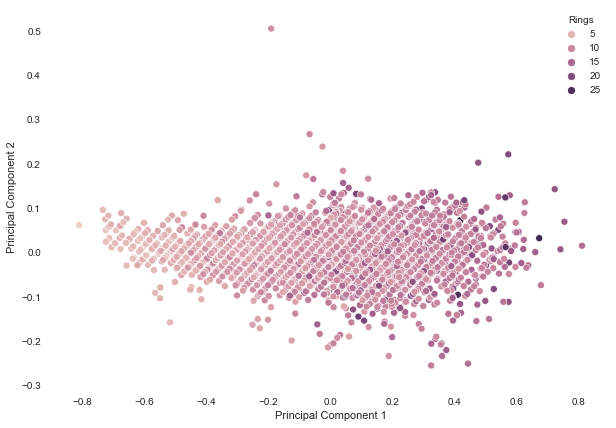

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_encoded[clustering_cols])

principal_df = pd.DataFrame(data = principalComponents , columns = ['Principal Component 1', 'Principal Component 2'])
finalDf = pd.concat([principal_df, data['Gender']], axis = 1)
# finalDf = pd.concat([principal_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y= 'Principal Component 2', hue=target, data=finalDf)
plt.savefig('images/07 PCA Rings Scatter.png',bbox_inches = 'tight');

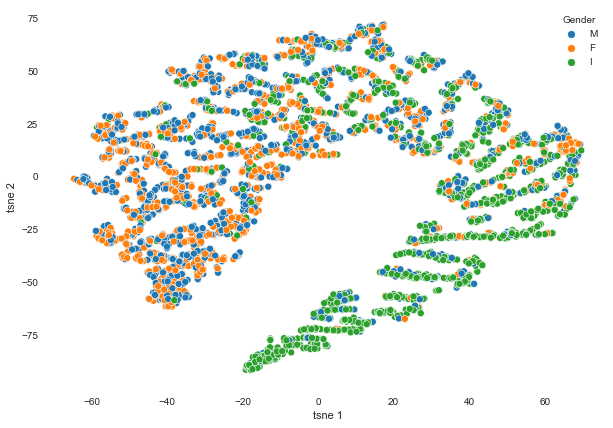

In [38]:
from sklearn.manifold import TSNE
data_tsne = TSNE(n_components=2).fit_transform(data_encoded[clustering_cols])

tsne_df = pd.DataFrame(data = data_tsne , columns = ['tsne 1', 'tsne 2'])
tsne_df_final = pd.concat([tsne_df, data['Gender']], axis = 1)
# tsne_df_final = pd.concat([tsne_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne 1', y= 'tsne 2', hue='Gender', data=tsne_df_final)
plt.savefig('images/08 tsne gender Scatter.png',bbox_inches = 'tight');

#### Feature Selection

In [40]:
cont_cols.append('Rings')

In [41]:
clustering_cols_gender = ['Diameter', 'Height', 'Shell weight','Gender_F', 'Gender_I', 'Gender_M']

In [42]:
data_encoded['Gender_F'] = data_encoded['Gender_F'].astype(object)
data_encoded['Gender_M'] = data_encoded['Gender_M'].astype(object)
data_encoded['Gender_I'] = data_encoded['Gender_I'].astype(object)

In [43]:
gower = gower_distance(data_encoded[clustering_cols_gender])

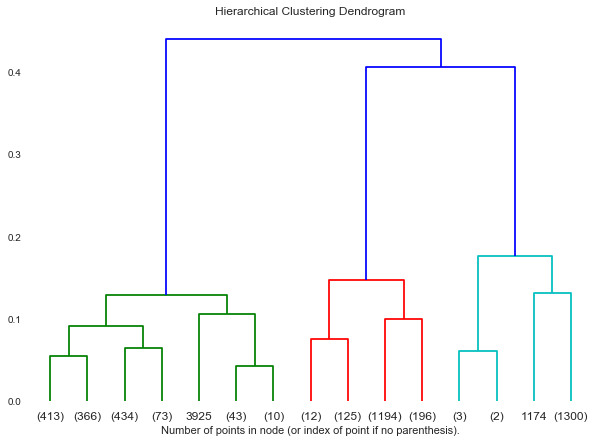

In [44]:
from sklearn.cluster import AgglomerativeClustering
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average")

model = model.fit(gower)

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()
plt.savefig('images/08 Dendogram.png',bbox_inches = 'tight');

In [45]:
from sklearn.cluster import AgglomerativeClustering

elbow_df = pd.DataFrame(columns=['n_clusters', 'gower_total'])
i = 0
for n_clusters in range(1,11):
    gower_total = 0
    
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="precomputed", linkage="average")
    model = model.fit(gower)
    
    data_encoded_clustered = pd.concat([data_encoded,pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    gower_total = cluster_score(data_encoded_clustered, metric='gower')
    
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'gower_total'] = gower_total
    
    i = i +1
    
    del data_encoded_clustered

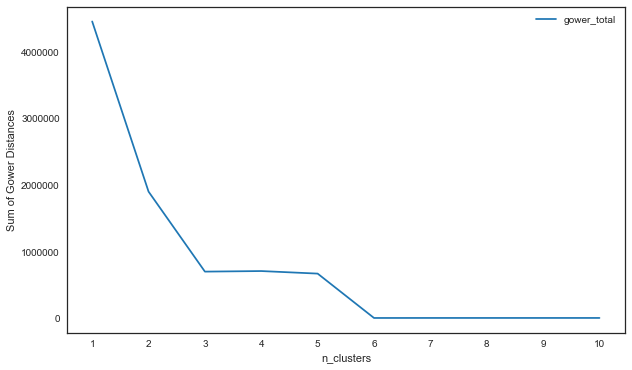

In [46]:
plt.style.use('seaborn-white')
elbow_df.plot.line(x='n_clusters',y='gower_total',xticks=range(1,11),figsize=(10,6),ylabel="Sum of Gower Distances")
plt.savefig('images/09 Gower Elbow.png',bbox_inches = 'tight');

In [47]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

elbow_df = pd.DataFrame(columns=['n_clusters', 'sum_square_total', 'silhouette_avg'])
i = 0
# cluster_total = 0 
for n_clusters in range(2,15):
    
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward")
    model = model.fit(data_encoded[clustering_cols])
    
    data_encoded_clustered = pd.concat([data_encoded[clustering_cols],pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    centroids = centroid_calc(data_encoded_clustered, clustering_cols)

    elbow_df.loc[i,'sum_square_total'] = sum_of_squares(centroids, data_encoded_clustered,clustering_cols)
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'silhouette_avg'] = silhouette_score(data_encoded_clustered[clustering_cols], data_encoded_clustered['Cluster'])
    
    i = i +1
    
#     del data_encoded_clustered

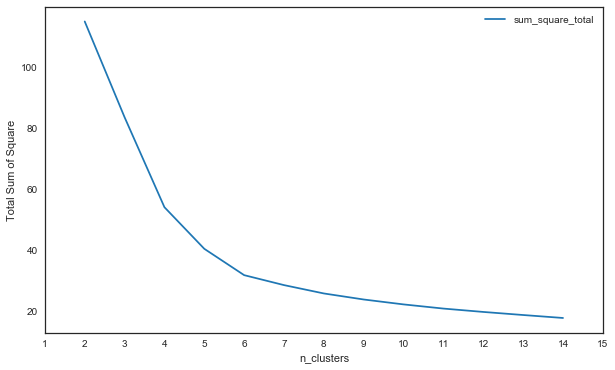

In [48]:
plt.style.use('seaborn-white')
elbow_df.plot.line(x='n_clusters',y='sum_square_total',xticks=range(1,16),figsize=(10,6),ylabel="Total Sum of Square")
plt.savefig('images/09 Sum Square Elbow.png',bbox_inches = 'tight');

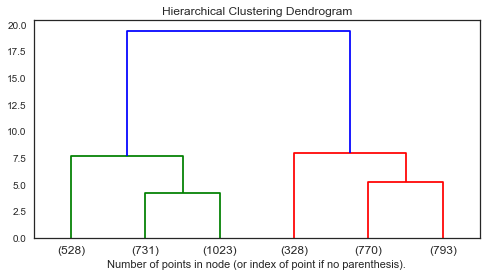

In [49]:
from sklearn.cluster import AgglomerativeClustering
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="euclidean", linkage="ward")

model = model.fit(data_encoded[clustering_cols])

plt.figure(figsize=(8, 4))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()
plt.savefig('images/08 Dendogram.png',bbox_inches = 'tight');

In [130]:
final_model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
final_model = final_model.fit(data_encoded[clustering_cols])

data_encoded_clustered = pd.concat([data_encoded[clustering_cols],pd.Series(final_model.labels_)], axis=1)
data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
data_encoded_clustered = pd.concat([data_encoded_clustered,target], axis=1)

centroids = centroid_calc(data_encoded_clustered, clustering_cols)

In [122]:
pd.DataFrame(centroids).to_csv('centroids.csv')

In [123]:
for i in range(centroids.shape[0]):
    
    data_encoded_clustered[data_encoded_clustered['Cluster'] == i].describe().to_csv('desc_stats/desc_stats_' + str(i) + '.csv')

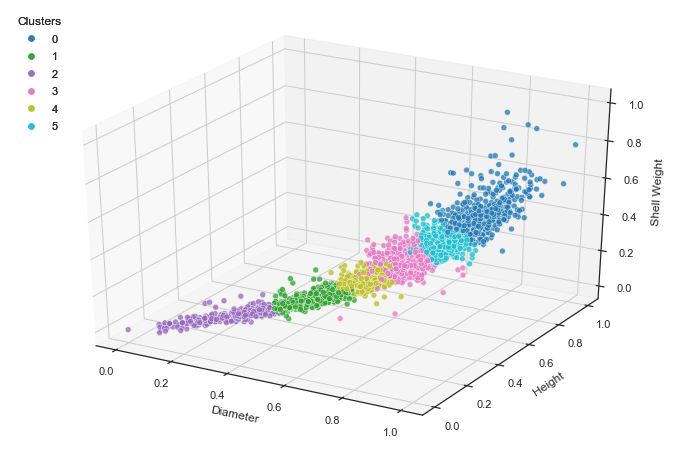

In [131]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')



scatter = ax.scatter(data_encoded_clustered['Diameter'], data_encoded_clustered['Height'], data_encoded_clustered['Shell weight'], c=data_encoded_clustered['Cluster'], cmap='tab10',alpha=0.75,edgecolors='w',linewidths=0.5,s=35);
ax.set(xlabel='Diameter', ylabel='Height', zlabel = 'Shell Weight')
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)
plt.savefig('images/09 3D Clusters Scatter.png',bbox_inches = 'tight');

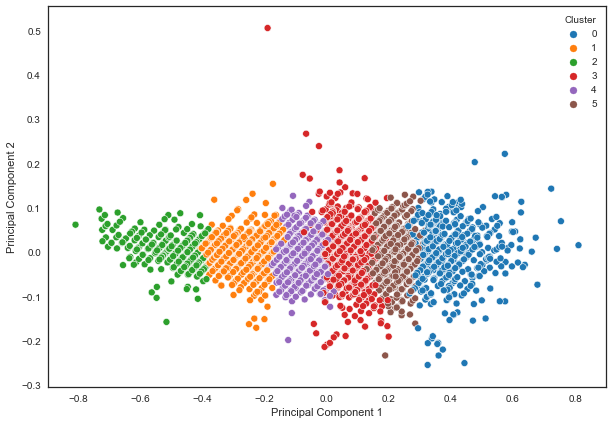

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_encoded[clustering_cols])

principal_df = pd.DataFrame(data = principalComponents , columns = ['Principal Component 1', 'Principal Component 2'])
finalDf = pd.concat([principal_df, data_encoded_clustered['Cluster']], axis = 1)
# finalDf = pd.concat([principal_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y= 'Principal Component 2', hue='Cluster', data=finalDf, palette='tab10')
plt.savefig('images/09 PCA Clusters Scatter.png',bbox_inches = 'tight');

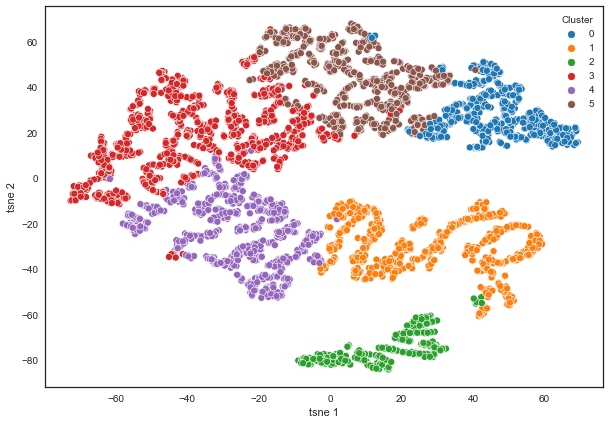

In [54]:
from sklearn.manifold import TSNE
data_tsne = TSNE(n_components=2).fit_transform(data_encoded[clustering_cols])

tsne_df = pd.DataFrame(data = data_tsne , columns = ['tsne 1', 'tsne 2'])
tsne_df_final = pd.concat([tsne_df, data_encoded_clustered['Cluster']], axis = 1)
# tsne_df_final = pd.concat([tsne_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne 1', y= 'tsne 2', hue='Cluster', data=tsne_df_final, palette='tab10')
plt.savefig('images/08 tsne Cluster Scatter.png',bbox_inches = 'tight');

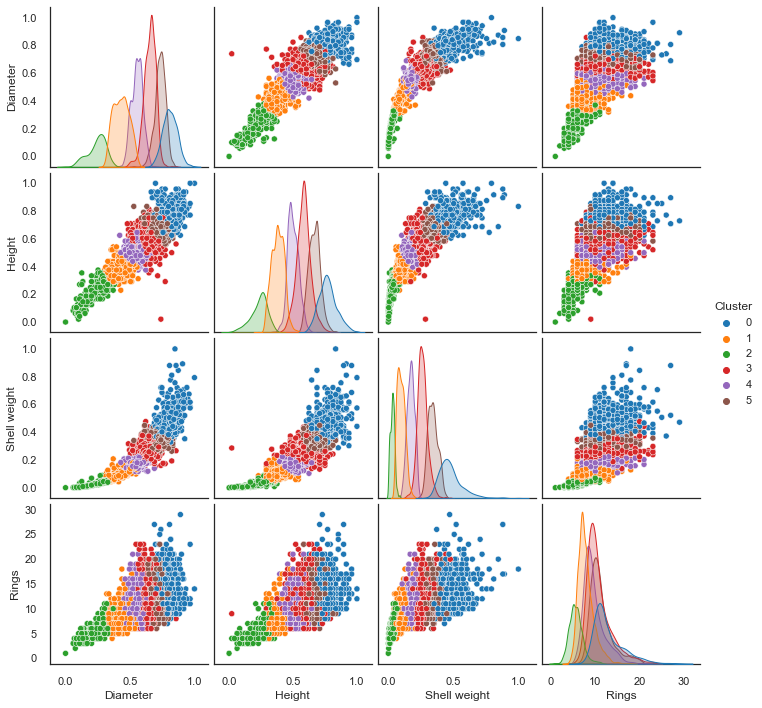

In [132]:
sns.set_theme(style="white")
sns.pairplot(data_encoded_clustered, hue='Cluster', palette='tab10')
plt.savefig('images/11 splom after clustering.png',bbox_inches = 'tight');

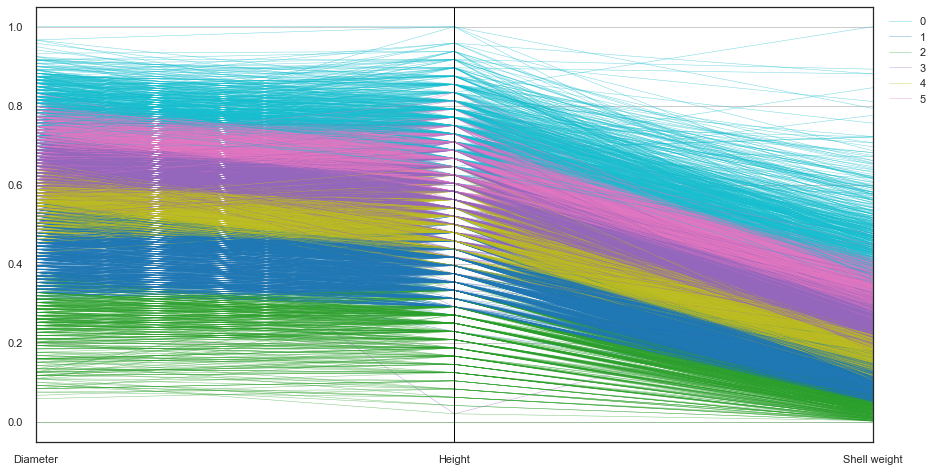

In [139]:
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']], 'Cluster', colormap='tab10',sort_labels=1, linewidth=0.5, alpha=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,bbox_to_anchor=(1.075, 1),fancybox =1, shadow =True, framealpha =0.8)

plt.savefig('images/012 Parallel Clusters.png',bbox_inches = 'tight');

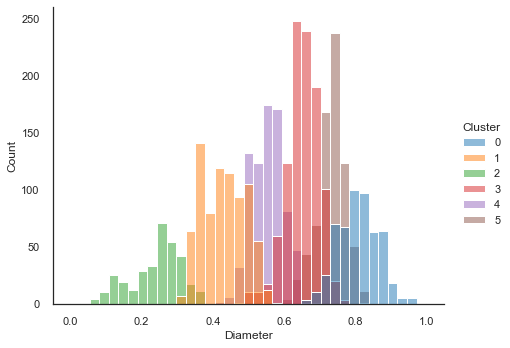

In [72]:
sns.displot(data_encoded_clustered, x="Diameter", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/12 Diameter Hist.png',bbox_inches = 'tight');

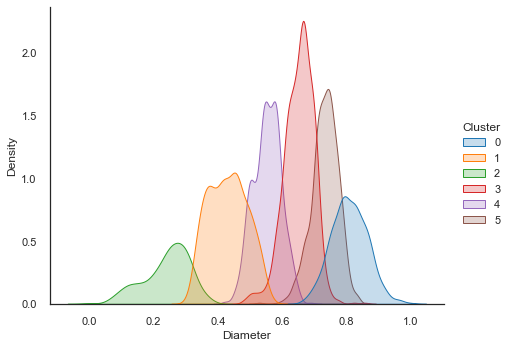

In [73]:
sns.displot(data_encoded_clustered, x="Diameter", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/12 Diameter KDE.png',bbox_inches = 'tight');

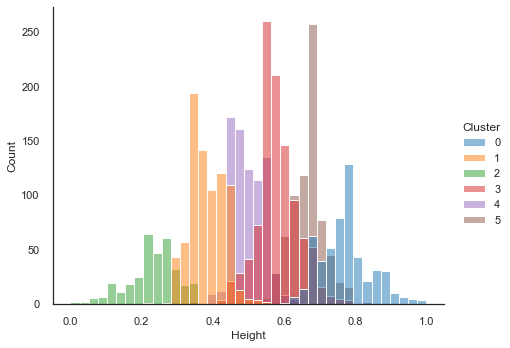

In [74]:
sns.displot(data_encoded_clustered, x="Height", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/13 Height Hist.png',bbox_inches = 'tight');

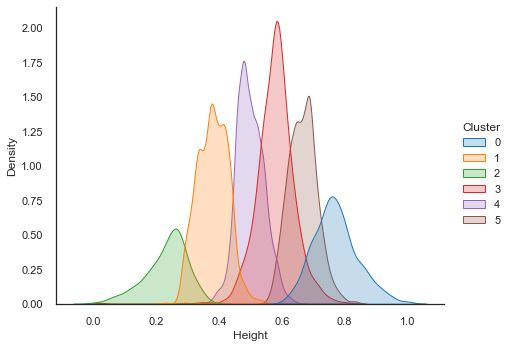

In [85]:
ax = sns.displot(data_encoded_clustered, x="Height", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/13 Height KDE.png',bbox_inches = 'tight');

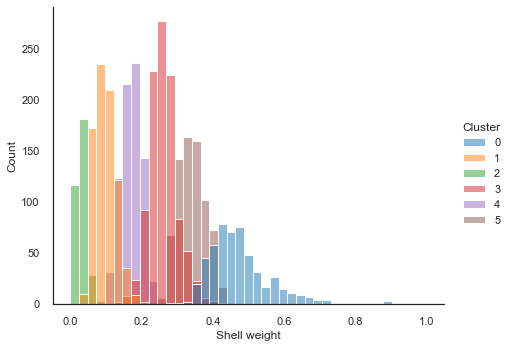

In [97]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/14 Shell weight Hist.png',bbox_inches = 'tight');

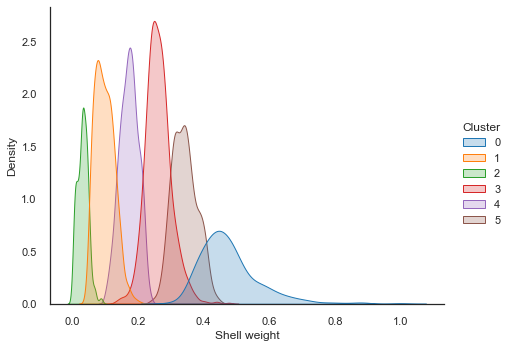

In [98]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/14 Shell weight KDE.png',bbox_inches = 'tight');

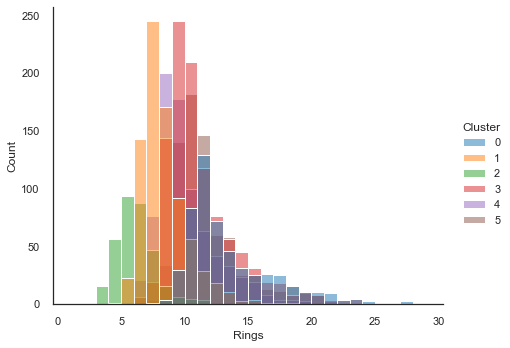

In [99]:
sns.displot(data_encoded_clustered, x="Rings", hue="Cluster", palette='tab10',aspect=1.3, kind="hist",binwidth=1)
plt.savefig('images/15 Rings Hist.png',bbox_inches = 'tight');

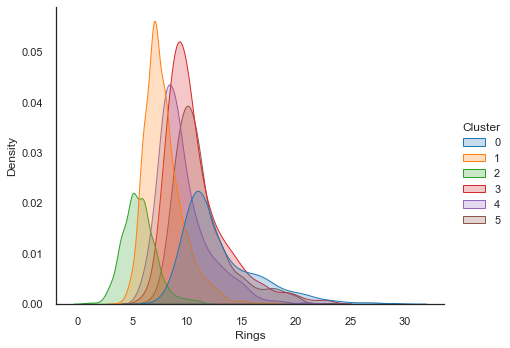

In [137]:
sns.displot(data_encoded_clustered, x="Rings", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/15 Rings KDE.png',bbox_inches = 'tight');

In [148]:
for i in range(len(data_encoded_clustered)):
    
    if data_encoded_clustered.loc[i,'Rings'] <= 6:
        
        data_encoded_clustered.loc[i,'Classified'] = 0.75
    
    elif data_encoded_clustered.loc[i,'Rings'] <= 9:
        
        data_encoded_clustered.loc[i,'Classified'] = 0.50
        
    elif data_encoded_clustered.loc[i,'Rings'] <= 10:
        
        data_encoded_clustered.loc[i,'Classified'] = 1
    
    else: data_encoded_clustered.loc[i,'Classified'] = 0.25

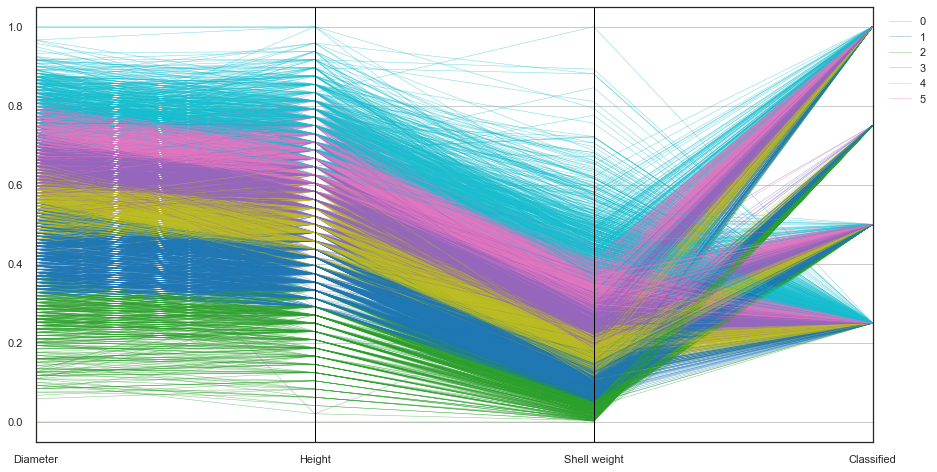

In [149]:
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster', 'Classified']], 'Cluster', colormap='tab10',sort_labels=1, linewidth=0.5, alpha=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,bbox_to_anchor=(1.075, 1),fancybox =1, shadow =True, framealpha =0.8)

plt.savefig('images/013 Parallel Clusters with classification.png',bbox_inches = 'tight');

In [142]:
data_encoded_clustered.loc[0,'Rings']

15

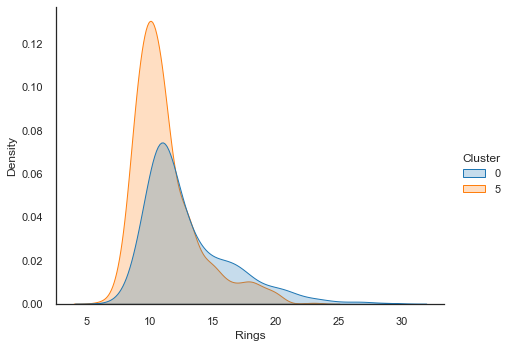

In [138]:
test = data_encoded_clustered[data_encoded_clustered['Cluster'].isin([0,5])]
sns.displot(test, x="Rings", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/16 Rings KDE CLuster 0 and 5.png',bbox_inches = 'tight');

In [106]:
data_encoded

Length  Diameter    Height  Whole weight  Shucked weight  \
0     0.513514  0.521008  0.354167      0.181335        0.150303   
1     0.371622  0.352941  0.333333      0.079157        0.066241   
2     0.614865  0.613445  0.520833      0.239065        0.171822   
3     0.493243  0.521008  0.479167      0.182044        0.144250   
4     0.344595  0.336134  0.291667      0.071897        0.059516   
...        ...       ...       ...           ...             ...   
4168  0.662162  0.663866  0.645833      0.313441        0.248151   
4169  0.695946  0.647059  0.520833      0.341420        0.294553   
4170  0.709459  0.705882  0.812500      0.415796        0.352724   
4171  0.743243  0.722689  0.583333      0.386931        0.356422   
4172  0.858108  0.840336  0.770833      0.689393        0.635171   

      Viscera weight  Shell weight Gender_F Gender_I Gender_M  
0           0.132324      0.147982        0        0        1  
1           0.063199      0.068261        0        0        1  
2           0.185648      0.207773        1        0        0  
3           0.149440      0.152965        0        0        1  
4           0.051350      0.053313        0        1        0  
...              ...           ...      ...      ...      ...  
4168        0.314022      0.246637        1        0        0  
4169        0.281764      0.258097        0        0        1  
4170        0.377880      0.305431        0        0        1  
4171        0.342989      0.293473        1        0        0  
4172        0.495063      0.491779        0        0        1  

[4173 rows x 10 columns]

In [125]:
from sklearn.cluster import KMeans
final_model2 = KMeans(n_clusters=2).fit(data_encoded)
# final_model2 = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
# final_model = final_model.fit(data_encoded[clustering_cols])

data_encoded_clustered_k_means = pd.concat([data_encoded[clustering_cols],pd.Series(final_model2.labels_)], axis=1)
data_encoded_clustered_k_means = data_encoded_clustered_k_means.rename(columns={0:'Cluster'})
data_encoded_clustered_k_means = pd.concat([data_encoded_clustered_k_means,target], axis=1)

centroids_k_means = centroid_calc(data_encoded_clustered_k_means, clustering_cols)

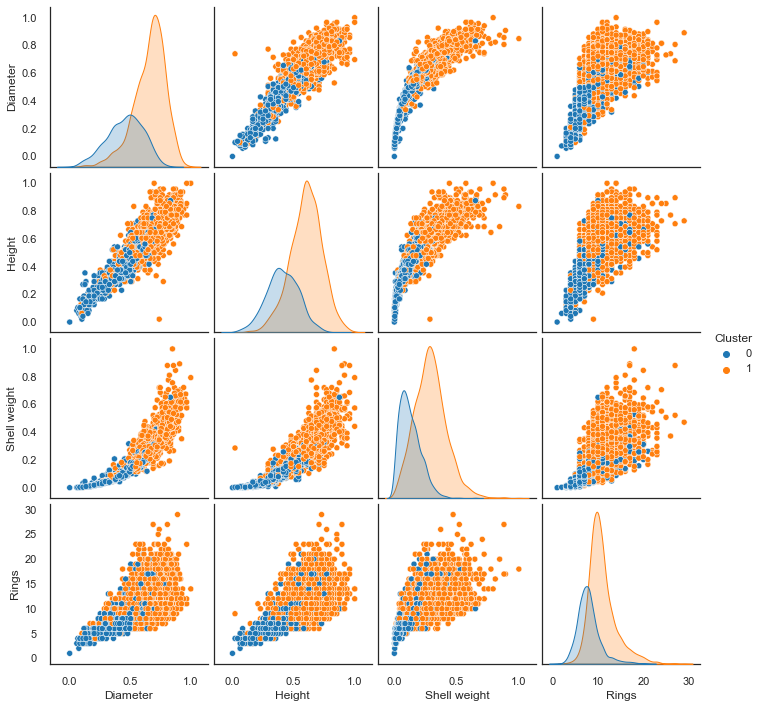

In [126]:
sns.set_theme(style="white")
sns.pairplot(data_encoded_clustered_k_means, hue='Cluster', palette='tab10')
# plt.savefig('images/11 splom after clustering.png',bbox_inches = 'tight');

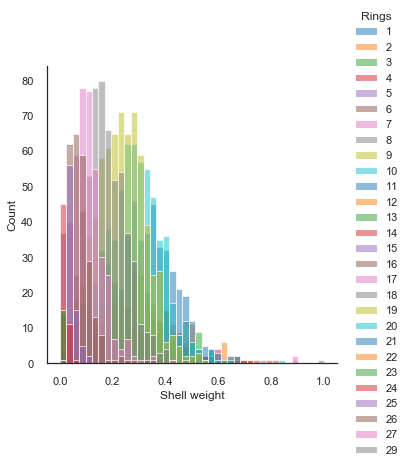

In [348]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Rings", palette='tab10')

In [405]:
order = [0,1,2,3,4,5]

In [413]:
handles_plot = [handles[idx] for idx in order]

In [415]:
labels_plot = [print(labels[idx]) for idx in order]

1
4
3
5
0
2


In [ ]:
labels

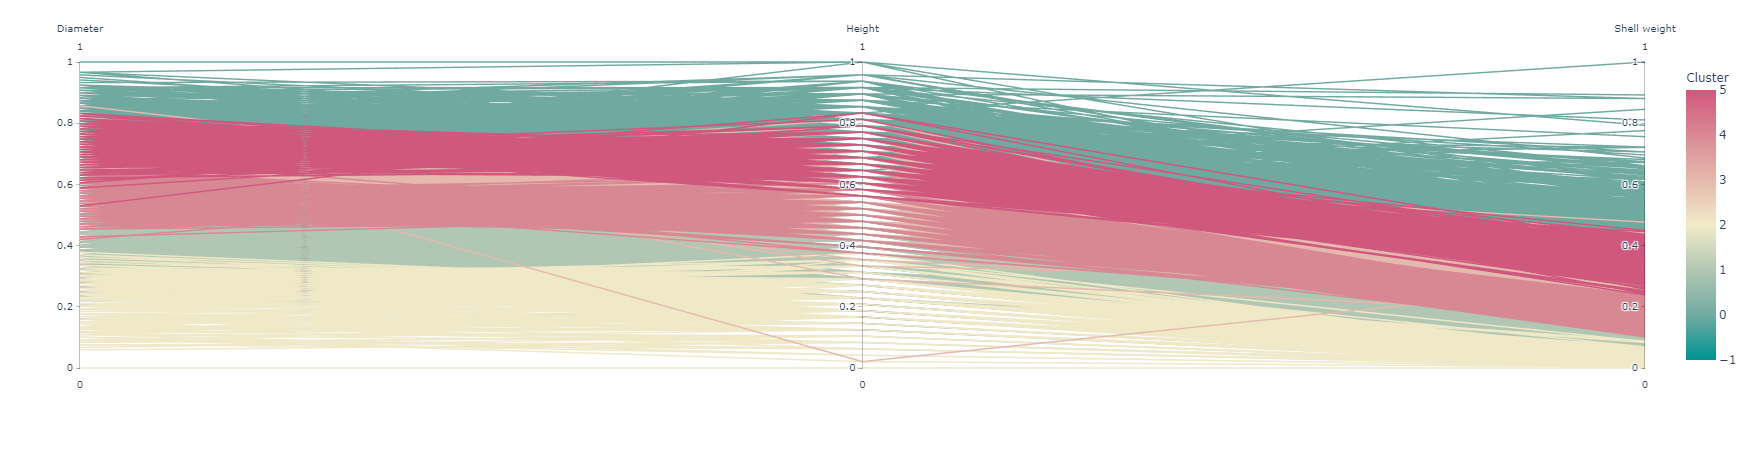

In [394]:
import plotly.express as px
fig = px.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']], color="Cluster",
                              dimensions=['Diameter', 'Height', 'Shell weight'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

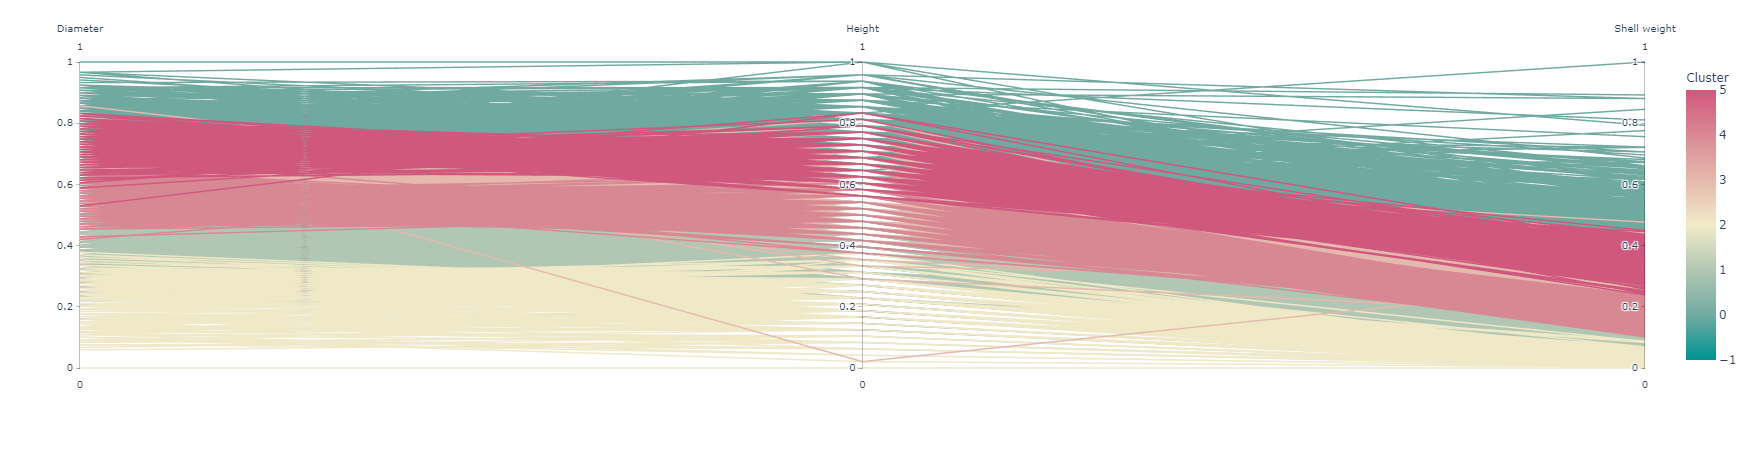

In [396]:
fig.show()

In [365]:
data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']].sort_values('Cluster')

Diameter    Height  Shell weight  Cluster
2086  0.840336  0.708333      0.490284        0
1758  0.857143  0.854167      0.571500        0
1759  0.907563  0.812500      0.626308        0
1760  0.949580  0.770833      0.638266        0
1761  0.966387  1.000000      0.574489        0
...        ...       ...           ...      ...
1916  0.689076  0.625000      0.295466        5
1515  0.773109  0.708333      0.392128        5
1917  0.731092  0.645833      0.349278        5
1919  0.697479  0.708333      0.318386        5
1678  0.773109  0.687500      0.392128        5

[4173 rows x 4 columns]

In [167]:
model = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="average")
model = model.fit(data_encoded[cont_cols])

data_encoded_clustered = pd.concat([data_encoded[cont_cols],pd.Series(model.labels_)], axis=1)
data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})

In [209]:
total_dist = 0
for centroid in range(clf.centroids_.shape[0]):

    centroid_dist = 0
    for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == 1].index):

        centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[cont_cols].loc[i]) - clf.centroids_[centroid]).sum()

    total_dist = total_dist + centroid_dist

In [210]:
total_dist

114.72547925085624

In [187]:
clf.centroids_.shape[0]

5

In [203]:
np.square(list(data_encoded[cont_cols].loc[0]) - clf.centroids_[0]).sum()

0.5262160920319481

In [198]:
data_encoded_clustered

Length  Diameter    Height  Whole weight  Shucked weight  \
0     0.513514  0.521008  0.354167      0.181335        0.150303   
1     0.371622  0.352941  0.333333      0.079157        0.066241   
2     0.614865  0.613445  0.520833      0.239065        0.171822   
3     0.493243  0.521008  0.479167      0.182044        0.144250   
4     0.344595  0.336134  0.291667      0.071897        0.059516   
...        ...       ...       ...           ...             ...   
4168  0.662162  0.663866  0.645833      0.313441        0.248151   
4169  0.695946  0.647059  0.520833      0.341420        0.294553   
4170  0.709459  0.705882  0.812500      0.415796        0.352724   
4171  0.743243  0.722689  0.583333      0.386931        0.356422   
4172  0.858108  0.840336  0.770833      0.689393        0.635171   

      Viscera weight  Shell weight  Cluster  
0           0.132324      0.147982        3  
1           0.063199      0.068261        2  
2           0.185648      0.207773        3  
3           0.149440      0.152965        3  
4           0.051350      0.053313        2  
...              ...           ...      ...  
4168        0.314022      0.246637        3  
4169        0.281764      0.258097        3  
4170        0.377880      0.305431        0  
4171        0.342989      0.293473        0  
4172        0.495063      0.491779        0  

[4173 rows x 8 columns]